<a href="https://colab.research.google.com/github/Shreyas-Hegde10/MNIST-Deep-Learning/blob/main/image_classification_using_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import optuna

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Loading Data

In [ ]:
dataset = MNIST(root='data/', download=True)
len(dataset)#60,000 samples

test_dataset = MNIST(root='data/', train=False)
len(test_dataset) #10,000 samples

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 44598030.58it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1963746.94it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13837262.35it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6562359.20it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



10000

Viewing Samples

Label: 5


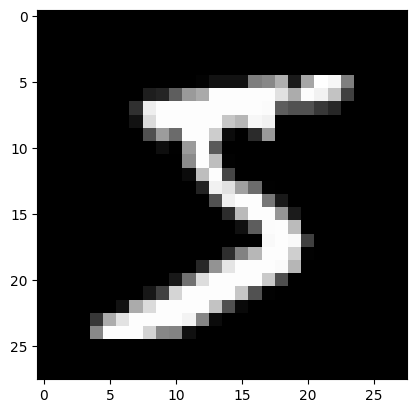

In [ ]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)



Label: 3


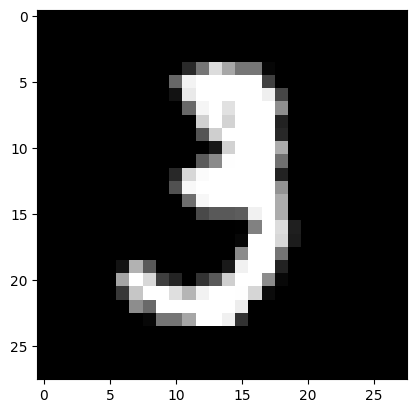

In [ ]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

Transforming Images Into Tensors

In [ ]:
transformed_ds = MNIST(root='data/', train=True, transform=transforms.ToTensor())
img_tensor, label = transformed_ds[0]
print(img_tensor, label)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

Training and Validation Datasets

In [ ]:
train_ds, val_ds = random_split(transformed_ds, [50000,10000])
len(train_ds),len(val_ds)

(50000, 10000)

In [ ]:
#  Loading data in batches
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Baseline Model

In [ ]:
input_size = 28*28
num_classes = 10

In [ ]:
# Extending Mnist Model class
class MnistModel(nn.Module):
    #Class constructor
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    # Method that generates outputs
    def forward(self,xb):
        xb = xb.reshape(-1,784) # Reshaping images into a 2-d tensor(vector) with a size of 784
        output = self.linear(xb)
        return output

    # Method that generates predictions and losses for the training batch
    def training_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    # Method that generates predictions, accuracies, & losses for the validation batch
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out,labels)
        return {"val_loss": loss, "val_acc": acc}

    # Method that generates mean losses and accuracies for the entire validation batch size
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    # Method that formats the epoch losses and accuracies for the validation batch size
    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()


In [ ]:
# Generating outputs on the training set
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs.shape:', outputs.shape)
print('Sample outputs :\n', outputs[:2].data) # Some probabilities are negative


outputs.shape: torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.1579,  0.2903,  0.1580,  0.6354,  0.0769, -0.2044, -0.2965,  0.0740,
          0.2596, -0.0828],
        [ 0.1851, -0.1541,  0.0672,  0.2038,  0.2340,  0.1945, -0.1220,  0.1313,
         -0.1091,  0.0353]])


In [ ]:
# Using Softmax to convert all probabilities to be between 0 & 1
probs = F.softmax(outputs, dim=1)
print("Sample probabilities:\n", probs[:2].data)
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1018, 0.1163, 0.1019, 0.1642, 0.0939, 0.0709, 0.0647, 0.0936, 0.1127,
         0.0800],
        [0.1115, 0.0794, 0.0991, 0.1136, 0.1171, 0.1126, 0.0820, 0.1057, 0.0831,
         0.0960]])
Sum:  1.0


In [ ]:
# Picking the class with the highest probability
max_probs, preds = torch.max(probs,dim=1)
print(preds)
print(max_probs)

tensor([3, 4, 3, 3, 0, 3, 4, 4, 4, 3, 7, 3, 5, 1, 4, 0, 3, 3, 7, 0, 3, 4, 7, 3,
        5, 7, 9, 7, 7, 9, 4, 8, 9, 3, 7, 4, 3, 7, 3, 3, 3, 0, 3, 3, 3, 3, 7, 0,
        3, 4, 0, 8, 8, 9, 3, 4, 3, 3, 6, 7, 4, 3, 3, 4, 3, 4, 4, 9, 8, 4, 5, 3,
        3, 3, 7, 7, 3, 3, 3, 4, 4, 3, 3, 6, 3, 3, 8, 8, 5, 4, 4, 8, 3, 3, 3, 7,
        8, 3, 3, 0, 8, 3, 4, 2, 4, 3, 3, 6, 8, 4, 8, 3, 8, 3, 7, 8, 3, 6, 8, 2,
        8, 3, 7, 3, 4, 8, 8, 3])
tensor([0.1642, 0.1171, 0.1247, 0.1192, 0.1208, 0.1203, 0.1224, 0.1168, 0.1234,
        0.1166, 0.1248, 0.1230, 0.1176, 0.1149, 0.1281, 0.1295, 0.1502, 0.1291,
        0.1248, 0.1141, 0.1280, 0.1166, 0.1263, 0.1230, 0.1464, 0.1328, 0.1270,
        0.1120, 0.1257, 0.1327, 0.1309, 0.1371, 0.1221, 0.1643, 0.1274, 0.1231,
        0.1343, 0.1135, 0.1183, 0.1150, 0.1176, 0.1314, 0.1262, 0.1256, 0.1345,
        0.1171, 0.1304, 0.1122, 0.1266, 0.1166, 0.1178, 0.1293, 0.1334, 0.1246,
        0.1489, 0.1323, 0.1264, 0.1182, 0.1128, 0.1338, 0.1472, 0.1737, 0.1281,
       

In [ ]:
# Evaluation metric: accuracy
def accuracy(outputs,labels):
    _, preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds)) # No need to apply softmax since e^x is an increasing function; if y1>y2, then e^y1 > e^y2

In [ ]:
# Loss function: cross-entropy
loss_fn = F.cross_entropy
loss = loss_fn(outputs,labels)
print(loss)

tensor(2.3101, grad_fn=<NllLossBackward0>)


Training the Model

In [ ]:
# Defining a function that starts the training loop based on a specific batch size
def fit(epochs,lr,model,train_dataset,val_dataset,batch_quant, opt_func=torch.optim.SGD):
    train_loader = DataLoader(train_dataset, batch_size=batch_quant, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_quant)

    optimizer = opt_func(model.parameters(), lr)
    history = []

    for epoch in range(epochs):
        # Training stage
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation stage
        result = evaluate(model, val_loader)
        model.epoch_end(epoch,result)
        history.append(result)

    return history



In [ ]:
# Creating a function that generates averages validation accuracies and losses
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
history1 = fit(5, 0.001, model, train_ds, val_ds, batch_quant = 128)

Epoch [0], val_loss: 1.9445, val_acc: 0.6303
Epoch [1], val_loss: 1.6762, val_acc: 0.7333
Epoch [2], val_loss: 1.4757, val_acc: 0.7683
Epoch [3], val_loss: 1.3245, val_acc: 0.7853
Epoch [4], val_loss: 1.2083, val_acc: 0.7953


In [ ]:
history2 = fit(5, 0.001, model, train_ds, val_ds, batch_quant = 128)

Epoch [0], val_loss: 1.1169, val_acc: 0.8059
Epoch [1], val_loss: 1.0437, val_acc: 0.8154
Epoch [2], val_loss: 0.9838, val_acc: 0.8229
Epoch [3], val_loss: 0.9340, val_acc: 0.8258
Epoch [4], val_loss: 0.8920, val_acc: 0.8291


In [ ]:
history3 = fit(5, 0.001, model, train_ds, val_ds, batch_quant = 128)

Epoch [0], val_loss: 0.8560, val_acc: 0.8329
Epoch [1], val_loss: 0.8248, val_acc: 0.8356
Epoch [2], val_loss: 0.7975, val_acc: 0.8383
Epoch [3], val_loss: 0.7733, val_acc: 0.8402
Epoch [4], val_loss: 0.7518, val_acc: 0.8428


In [ ]:
history4 = fit(5, 0.001, model, train_ds, val_ds, batch_quant = 128)

Epoch [0], val_loss: 0.7326, val_acc: 0.8449
Epoch [1], val_loss: 0.7152, val_acc: 0.8465
Epoch [2], val_loss: 0.6993, val_acc: 0.8478
Epoch [3], val_loss: 0.6849, val_acc: 0.8502
Epoch [4], val_loss: 0.6717, val_acc: 0.8517


Text(0.5, 1.0, 'Accuracy Compared To # of Epochs')

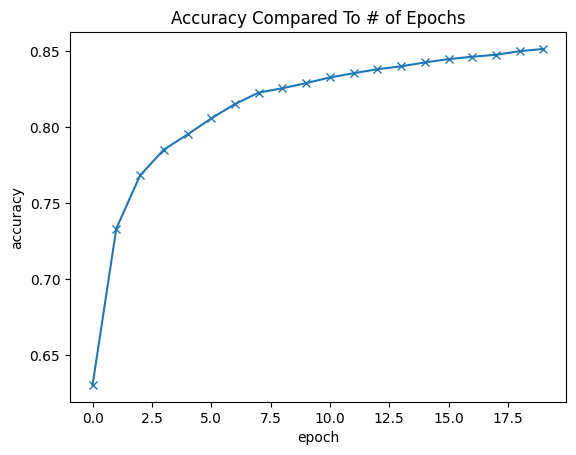

In [ ]:
history = history1+history2+history3+history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Compared To # of Epochs')

Hyperparameter Tuning

In [ ]:
# Defining objective function
def objective(trial):

    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('lr', 1e-3, 1e-1)
    batch_size = trial.suggest_int('batch_size', 64,512)

    # Create the model
    model = MnistModel()

    # Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Train and val loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)


    num_epochs = 5
    for epoch in range(num_epochs):
        for batch in train_loader:

             # Training Loop
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation Stage
        result = evaluate(model, val_loader)

    return result['val_acc']






In [ ]:
# Create a study object
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Number of trials

# Get the best trial
best_trial = study.best_trial

# Print the best hyperparameters, best accuracy, and trial number
print(f"Best hyperparameters: {best_trial.params}")
print(f"Best test accuracy: {best_trial.value:.4f}")
print(f"Trial number with best test accuracy: {best_trial.number}")

[I 2024-08-08 19:12:07,994] A new study created in memory with name: no-name-f306bc51-e426-40b1-948e-26107d6a8d49
<ipython-input-24-8e5b843462b8>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2024-08-08 19:12:50,348] Trial 0 finished with value: 0.8455597162246704 and parameters: {'lr': 0.00904110131958701, 'batch_size': 365}. Best is trial 0 with value: 0.8455597162246704.
[I 2024-08-08 19:13:33,168] Trial 1 finished with value: 0.875388503074646 and parameters: {'lr': 0.024702264715233492, 'batch_size': 312}. Best is trial 1 with value: 0.875388503074646.
[I 2024-08-08 19:14:15,401] Trial 2 finished with value: 0.8079388737678528 and parameters: {'lr': 0.004501380352236096, 'batch_size': 478}. Best is trial 1 with value: 0.875388503074646.
[I 2024-08-08 19:14:57

Best hyperparameters: {'lr': 0.024702264715233492, 'batch_size': 312}
Best test accuracy: 0.8754
Trial number with best test accuracy: 1


Training With Best Hyperparameters

In [ ]:
# Best hyperparameters
{'lr': 0.08285848103758864, 'batch_size': 184} # Set A
{'lr': 0.024702264715233492, 'batch_size': 312} # Set B

In [ ]:
hyperparam_model = MnistModel()

In [ ]:
setA_history1 = fit(5,0.08285848103758864 , hyperparam_model, train_ds, val_ds, batch_quant = 184)

Epoch [0], val_loss: 0.4771, val_acc: 0.8782
Epoch [1], val_loss: 0.4048, val_acc: 0.8922
Epoch [2], val_loss: 0.3741, val_acc: 0.8977
Epoch [3], val_loss: 0.3564, val_acc: 0.9014
Epoch [4], val_loss: 0.3429, val_acc: 0.9045


In [ ]:
setA_history2 = fit(5,0.08285848103758864 , hyperparam_model, train_ds, val_ds, batch_quant = 184)

Epoch [0], val_loss: 0.3348, val_acc: 0.9056
Epoch [1], val_loss: 0.3278, val_acc: 0.9066
Epoch [2], val_loss: 0.3217, val_acc: 0.9087
Epoch [3], val_loss: 0.3181, val_acc: 0.9098
Epoch [4], val_loss: 0.3128, val_acc: 0.9118


In [ ]:
setA_history3 = fit(5,0.08285848103758864 , hyperparam_model, train_ds, val_ds, batch_quant = 184)

Epoch [0], val_loss: 0.3095, val_acc: 0.9130
Epoch [1], val_loss: 0.3068, val_acc: 0.9134
Epoch [2], val_loss: 0.3049, val_acc: 0.9134
Epoch [3], val_loss: 0.3024, val_acc: 0.9147
Epoch [4], val_loss: 0.3006, val_acc: 0.9154


In [ ]:
setA_history4 = fit(5,0.08285848103758864 , hyperparam_model, train_ds, val_ds, batch_quant = 184)

Epoch [0], val_loss: 0.2994, val_acc: 0.9154
Epoch [1], val_loss: 0.2963, val_acc: 0.9175
Epoch [2], val_loss: 0.2953, val_acc: 0.9159
Epoch [3], val_loss: 0.2939, val_acc: 0.9169
Epoch [4], val_loss: 0.2925, val_acc: 0.9176


In [ ]:
setA_history5 = fit(30,0.08285848103758864 , hyperparam_model, train_ds, val_ds, batch_quant = 184)

Epoch [0], val_loss: 0.2914, val_acc: 0.9180
Epoch [1], val_loss: 0.2904, val_acc: 0.9177
Epoch [2], val_loss: 0.2896, val_acc: 0.9192
Epoch [3], val_loss: 0.2888, val_acc: 0.9184
Epoch [4], val_loss: 0.2879, val_acc: 0.9182
Epoch [5], val_loss: 0.2869, val_acc: 0.9189
Epoch [6], val_loss: 0.2874, val_acc: 0.9185
Epoch [7], val_loss: 0.2857, val_acc: 0.9189
Epoch [8], val_loss: 0.2852, val_acc: 0.9201
Epoch [9], val_loss: 0.2846, val_acc: 0.9195
Epoch [10], val_loss: 0.2840, val_acc: 0.9194
Epoch [11], val_loss: 0.2836, val_acc: 0.9212
Epoch [12], val_loss: 0.2830, val_acc: 0.9204
Epoch [13], val_loss: 0.2825, val_acc: 0.9199
Epoch [14], val_loss: 0.2828, val_acc: 0.9200
Epoch [15], val_loss: 0.2814, val_acc: 0.9203
Epoch [16], val_loss: 0.2817, val_acc: 0.9207
Epoch [17], val_loss: 0.2809, val_acc: 0.9200
Epoch [18], val_loss: 0.2806, val_acc: 0.9207
Epoch [19], val_loss: 0.2800, val_acc: 0.9216
Epoch [20], val_loss: 0.2799, val_acc: 0.9217
Epoch [21], val_loss: 0.2794, val_acc: 0.921

Text(0.5, 1.0, 'Accuracy Compared To # of Epochs for Set A')

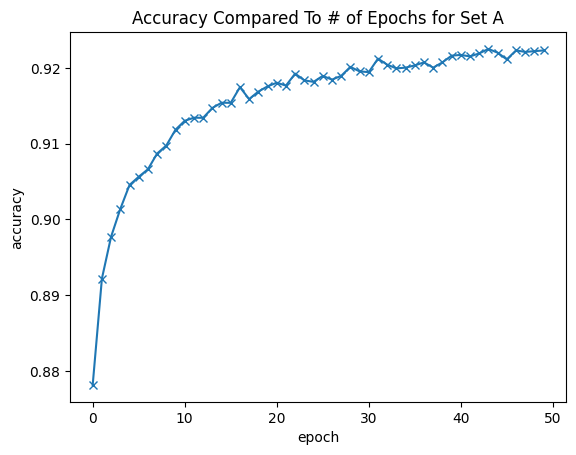

In [ ]:
history_setA = setA_history1 + setA_history2 + setA_history3 + setA_history4 + setA_history5
accuracies_setA = [result['val_acc'] for result in history_setA]
plt.plot(accuracies_setA, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Compared To # of Epochs for Set A')

In [ ]:
hyperparam_model_1 = MnistModel()

In [ ]:
setB_history1 = fit(5,0.024702264715233492, hyperparam_model_1, train_ds, val_ds, batch_quant = 312)

Epoch [0], val_loss: 0.8866, val_acc: 0.8259
Epoch [1], val_loss: 0.6695, val_acc: 0.8525
Epoch [2], val_loss: 0.5799, val_acc: 0.8634
Epoch [3], val_loss: 0.5297, val_acc: 0.8703
Epoch [4], val_loss: 0.4967, val_acc: 0.8757


In [ ]:
setB_history2 = fit(5,0.024702264715233492,hyperparam_model_1, train_ds, val_ds, batch_quant = 312)

Epoch [0], val_loss: 0.4728, val_acc: 0.8801
Epoch [1], val_loss: 0.4547, val_acc: 0.8816
Epoch [2], val_loss: 0.4404, val_acc: 0.8864
Epoch [3], val_loss: 0.4290, val_acc: 0.8881
Epoch [4], val_loss: 0.4189, val_acc: 0.8899


In [ ]:
setB_history3 = fit(5,0.024702264715233492,hyperparam_model_1, train_ds, val_ds, batch_quant = 312)

Epoch [0], val_loss: 0.4103, val_acc: 0.8913
Epoch [1], val_loss: 0.4036, val_acc: 0.8929
Epoch [2], val_loss: 0.3964, val_acc: 0.8953
Epoch [3], val_loss: 0.3907, val_acc: 0.8944
Epoch [4], val_loss: 0.3857, val_acc: 0.8955


In [ ]:
setB_history4 = fit(5,0.024702264715233492,hyperparam_model_1, train_ds, val_ds, batch_quant = 312)

Epoch [0], val_loss: 0.3811, val_acc: 0.8968
Epoch [1], val_loss: 0.3770, val_acc: 0.8974
Epoch [2], val_loss: 0.3730, val_acc: 0.8976
Epoch [3], val_loss: 0.3693, val_acc: 0.8987
Epoch [4], val_loss: 0.3661, val_acc: 0.8992


In [ ]:
setB_history5 = fit(30,0.024702264715233492,hyperparam_model_1, train_ds, val_ds, batch_quant = 312)

Epoch [0], val_loss: 0.3521, val_acc: 0.9022
Epoch [1], val_loss: 0.3501, val_acc: 0.9026
Epoch [2], val_loss: 0.3480, val_acc: 0.9036
Epoch [3], val_loss: 0.3461, val_acc: 0.9038
Epoch [4], val_loss: 0.3443, val_acc: 0.9038
Epoch [5], val_loss: 0.3424, val_acc: 0.9043
Epoch [6], val_loss: 0.3408, val_acc: 0.9053
Epoch [7], val_loss: 0.3394, val_acc: 0.9057
Epoch [8], val_loss: 0.3378, val_acc: 0.9064
Epoch [9], val_loss: 0.3364, val_acc: 0.9061
Epoch [10], val_loss: 0.3350, val_acc: 0.9062
Epoch [11], val_loss: 0.3340, val_acc: 0.9064
Epoch [12], val_loss: 0.3325, val_acc: 0.9071
Epoch [13], val_loss: 0.3313, val_acc: 0.9078
Epoch [14], val_loss: 0.3303, val_acc: 0.9067
Epoch [15], val_loss: 0.3290, val_acc: 0.9074
Epoch [16], val_loss: 0.3279, val_acc: 0.9077
Epoch [17], val_loss: 0.3269, val_acc: 0.9078
Epoch [18], val_loss: 0.3259, val_acc: 0.9083
Epoch [19], val_loss: 0.3251, val_acc: 0.9078
Epoch [20], val_loss: 0.3240, val_acc: 0.9087
Epoch [21], val_loss: 0.3232, val_acc: 0.908

In [ ]:
# Set A seems to be the better set of hyperparameters

Testing

In [ ]:
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=transforms.ToTensor())

In [ ]:
# Creating a function that predicts the digits
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


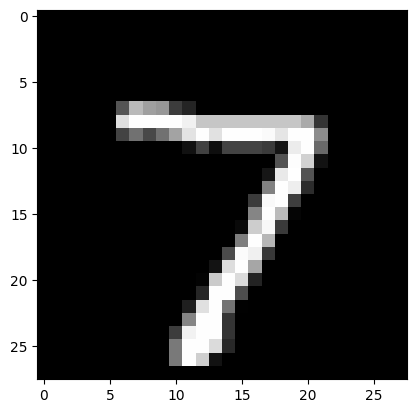

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, hyperparam_model))

Label: 2 , Predicted: 2


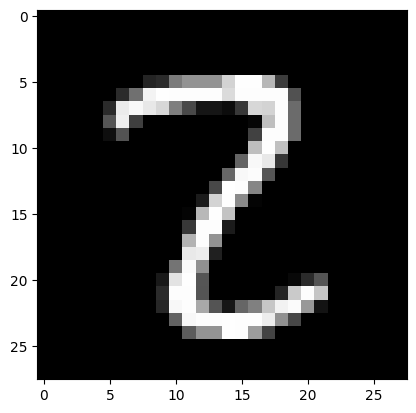

In [ ]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, hyperparam_model))

Label: 9 , Predicted: 3


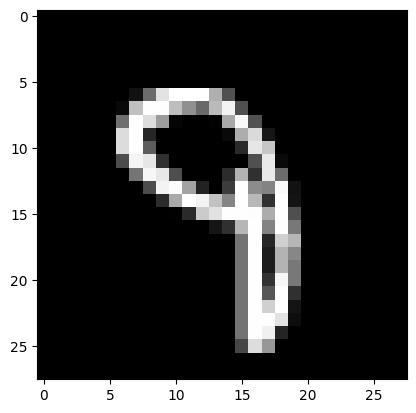

In [ ]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, hyperparam_model))

In [ ]:
test_loader = DataLoader(test_dataset, batch_size = 128)
result = evaluate(model, test_loader)
result

{'val_loss': 0.27149301767349243, 'val_acc': 0.9228639006614685}

In [ ]:
test_loader_setA = DataLoader(test_dataset, batch_size = 184)
result = evaluate(hyperparam_model, test_loader)
result

{'val_loss': 0.27233371138572693, 'val_acc': 0.9231606125831604}

In [ ]:
test_loader = DataLoader(test_dataset, batch_size = 312)
result = evaluate(hyperparam_model_1, test_loader)
result

{'val_loss': 0.2981164753437042, 'val_acc': 0.9168123602867126}